In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10, Flowers102
from torchgeo.datasets import UCMerced
from torchvision.models import alexnet
import torch.nn.functional as F
from tqdm import tqdm

from easyfsl.samplers import TaskSampler
from easyfsl.datasets import WrapFewShotDataset

from AlexNetLastTwoLayers import AlexNetLastTwoLayers
from PrototypicalNetworks_rebuttal import PrototypicalNetworks
from PrototypicalFlagNetworks_rebuttal import PrototypicalFlagNetworks
from PIL import Image



import copy

from statistics import mean

from matplotlib import pyplot as plt

import pandas as pd

import random

from eval import evaluate

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
random_seed = 0

random.seed(random_seed)
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
N_WAY = 5  # Number of classes in a task
N_QUERY = 10  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

transform = transforms.Compose(
        [
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225))
        ]
)



test_data = WrapFewShotDataset(
    Flowers102(
    root="../data",
    transform=transform,
    download=True,
    split = 'test')
)




Scrolling dataset's labels...: 100%|██████████| 6149/6149 [00:22<00:00, 269.52it/s]


In [5]:
#takes about 2hr with one GPU
results = pd.DataFrame(columns = ['Method', 'N Shots', 'Accuracy'])


for N_SHOT in [3,5,7]:
    print(f'Starting {N_SHOT}')
    test_sampler = TaskSampler(
            test_data, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
        )

    test_loader = DataLoader(
        test_data,
        batch_sampler=test_sampler,
        num_workers=0,
        pin_memory=True,
        collate_fn=test_sampler.episodic_collate_fn,
        shuffle = False
    )

    for random_seed in tqdm(range(20)):

        # # Eval Protonets
        random.seed(random_seed)
        alexnet_backbone1 = alexnet(pretrained = True)
        alexnet_backbone1 = AlexNetLastTwoLayers(alexnet_backbone1).to(DEVICE)
        proto_model = PrototypicalNetworks(alexnet_backbone1, head = 'ProtoNet').to(DEVICE)
        proto_acc = evaluate(proto_model, test_loader, DEVICE)
        row = pd.DataFrame(columns = results.columns,
                           data = [['ProtoNets', N_SHOT, proto_acc]])
        results = pd.concat([results, row])

        # # Eval Subspace Nets
        random.seed(random_seed)
        alexnet_backbone2 = alexnet(pretrained = True)
        alexnet_backbone2 = AlexNetLastTwoLayers(alexnet_backbone2).to(DEVICE)
        subspace_model = PrototypicalNetworks(alexnet_backbone2, head = 'SubspaceNet').to(DEVICE)
        subspace_acc = evaluate(subspace_model, test_loader, DEVICE)
        row = pd.DataFrame(columns = results.columns,
                           data = [['SubspaceNets', N_SHOT, subspace_acc]])
        results = pd.concat([results, row])

        # Eval Flag Nets
        random.seed(random_seed)
        alexnet_backbone3 = alexnet(pretrained = True)
        alexnet_backbone3 = AlexNetLastTwoLayers(alexnet_backbone3).to(DEVICE)
        flag_model = PrototypicalFlagNetworks(alexnet_backbone3, fl_type = [N_SHOT-1,N_SHOT-1]).to(DEVICE)
        flag_acc = evaluate(flag_model, test_loader, DEVICE)
        row = pd.DataFrame(columns = results.columns,
                           data = [['FlagNets', N_SHOT, flag_acc]])
        results = pd.concat([results, row])
        # print(results)

    results.to_csv('../results/flowers_probing_rebuttal1.csv')

Starting 3


  0%|          | 0/20 [00:00<?, ?it/s]/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_19250/4231393477.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant e

         Method N Shots  Accuracy
0     ProtoNets       3    0.8906
0  SubspaceNets       3    0.9118
0      FlagNets       3    0.9112


/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 10%|█         | 2/20 [05:13<47:09, 157.20s/it]

         Method N Shots  Accuracy
0     ProtoNets       3    0.8906
0  SubspaceNets       3    0.9118
0      FlagNets       3    0.9112
0     ProtoNets       3    0.8754
0  SubspaceNets       3    0.9002
0      FlagNets       3    0.8996


/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 15%|█▌        | 3/20 [08:03<46:08, 162.84s/it]

         Method N Shots  Accuracy
0     ProtoNets       3    0.8906
0  SubspaceNets       3    0.9118
0      FlagNets       3    0.9112
0     ProtoNets       3    0.8754
0  SubspaceNets       3    0.9002
0      FlagNets       3    0.8996
0     ProtoNets       3    0.8708
0  SubspaceNets       3    0.8984
0      FlagNets       3    0.8974


/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 20%|██        | 4/20 [10:31<41:49, 156.86s/it]

         Method N Shots  Accuracy
0     ProtoNets       3    0.8906
0  SubspaceNets       3    0.9118
0      FlagNets       3    0.9112
0     ProtoNets       3    0.8754
0  SubspaceNets       3    0.9002
0      FlagNets       3    0.8996
0     ProtoNets       3    0.8708
0  SubspaceNets       3    0.8984
0      FlagNets       3    0.8974
0     ProtoNets       3    0.8950
0  SubspaceNets       3    0.9094
0      FlagNets       3    0.9106


/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 25%|██▌       | 5/20 [13:00<38:33, 154.24s/it]

         Method N Shots  Accuracy
0     ProtoNets       3    0.8906
0  SubspaceNets       3    0.9118
0      FlagNets       3    0.9112
0     ProtoNets       3    0.8754
0  SubspaceNets       3    0.9002
0      FlagNets       3    0.8996
0     ProtoNets       3    0.8708
0  SubspaceNets       3    0.8984
0      FlagNets       3    0.8974
0     ProtoNets       3    0.8950
0  SubspaceNets       3    0.9094
0      FlagNets       3    0.9106
0     ProtoNets       3    0.8714
0  SubspaceNets       3    0.8954
0      FlagNets       3    0.8952


/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 30%|███       | 6/20 [15:25<35:15, 151.13s/it]

         Method N Shots  Accuracy
0     ProtoNets       3    0.8906
0  SubspaceNets       3    0.9118
0      FlagNets       3    0.9112
0     ProtoNets       3    0.8754
0  SubspaceNets       3    0.9002
0      FlagNets       3    0.8996
0     ProtoNets       3    0.8708
0  SubspaceNets       3    0.8984
0      FlagNets       3    0.8974
0     ProtoNets       3    0.8950
0  SubspaceNets       3    0.9094
0      FlagNets       3    0.9106
0     ProtoNets       3    0.8714
0  SubspaceNets       3    0.8954
0      FlagNets       3    0.8952
0     ProtoNets       3    0.8830
0  SubspaceNets       3    0.9030
0      FlagNets       3    0.9036


/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 35%|███▌      | 7/20 [17:53<32:31, 150.14s/it]

         Method N Shots  Accuracy
0     ProtoNets       3    0.8906
0  SubspaceNets       3    0.9118
0      FlagNets       3    0.9112
0     ProtoNets       3    0.8754
0  SubspaceNets       3    0.9002
0      FlagNets       3    0.8996
0     ProtoNets       3    0.8708
0  SubspaceNets       3    0.8984
0      FlagNets       3    0.8974
0     ProtoNets       3    0.8950
0  SubspaceNets       3    0.9094
0      FlagNets       3    0.9106
0     ProtoNets       3    0.8714
0  SubspaceNets       3    0.8954
0      FlagNets       3    0.8952
0     ProtoNets       3    0.8830
0  SubspaceNets       3    0.9030
0      FlagNets       3    0.9036
0     ProtoNets       3    0.8846
0  SubspaceNets       3    0.8968
0      FlagNets       3    0.8980


/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 40%|████      | 8/20 [20:18<29:41, 148.46s/it]

         Method N Shots  Accuracy
0     ProtoNets       3    0.8906
0  SubspaceNets       3    0.9118
0      FlagNets       3    0.9112
0     ProtoNets       3    0.8754
0  SubspaceNets       3    0.9002
0      FlagNets       3    0.8996
0     ProtoNets       3    0.8708
0  SubspaceNets       3    0.8984
0      FlagNets       3    0.8974
0     ProtoNets       3    0.8950
0  SubspaceNets       3    0.9094
0      FlagNets       3    0.9106
0     ProtoNets       3    0.8714
0  SubspaceNets       3    0.8954
0      FlagNets       3    0.8952
0     ProtoNets       3    0.8830
0  SubspaceNets       3    0.9030
0      FlagNets       3    0.9036
0     ProtoNets       3    0.8846
0  SubspaceNets       3    0.8968
0      FlagNets       3    0.8980
0     ProtoNets       3    0.8770
0  SubspaceNets       3    0.8986
0      FlagNets       3    0.8980


/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 45%|████▌     | 9/20 [22:49<27:20, 149.13s/it]

         Method N Shots  Accuracy
0     ProtoNets       3    0.8906
0  SubspaceNets       3    0.9118
0      FlagNets       3    0.9112
0     ProtoNets       3    0.8754
0  SubspaceNets       3    0.9002
0      FlagNets       3    0.8996
0     ProtoNets       3    0.8708
0  SubspaceNets       3    0.8984
0      FlagNets       3    0.8974
0     ProtoNets       3    0.8950
0  SubspaceNets       3    0.9094
0      FlagNets       3    0.9106
0     ProtoNets       3    0.8714
0  SubspaceNets       3    0.8954
0      FlagNets       3    0.8952
0     ProtoNets       3    0.8830
0  SubspaceNets       3    0.9030
0      FlagNets       3    0.9036
0     ProtoNets       3    0.8846
0  SubspaceNets       3    0.8968
0      FlagNets       3    0.8980
0     ProtoNets       3    0.8770
0  SubspaceNets       3    0.8986
0      FlagNets       3    0.8980
0     ProtoNets       3    0.8810
0  SubspaceNets       3    0.9050
0      FlagNets       3    0.9058


/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 50%|█████     | 10/20 [25:16<24:44, 148.50s/it]

         Method N Shots  Accuracy
0     ProtoNets       3    0.8906
0  SubspaceNets       3    0.9118
0      FlagNets       3    0.9112
0     ProtoNets       3    0.8754
0  SubspaceNets       3    0.9002
0      FlagNets       3    0.8996
0     ProtoNets       3    0.8708
0  SubspaceNets       3    0.8984
0      FlagNets       3    0.8974
0     ProtoNets       3    0.8950
0  SubspaceNets       3    0.9094
0      FlagNets       3    0.9106
0     ProtoNets       3    0.8714
0  SubspaceNets       3    0.8954
0      FlagNets       3    0.8952
0     ProtoNets       3    0.8830
0  SubspaceNets       3    0.9030
0      FlagNets       3    0.9036
0     ProtoNets       3    0.8846
0  SubspaceNets       3    0.8968
0      FlagNets       3    0.8980
0     ProtoNets       3    0.8770
0  SubspaceNets       3    0.8986
0      FlagNets       3    0.8980
0     ProtoNets       3    0.8810
0  SubspaceNets       3    0.9050
0      FlagNets       3    0.9058
0     ProtoNets       3    0.8828
0  SubspaceNet

/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 55%|█████▌    | 11/20 [27:45<22:17, 148.66s/it]

         Method N Shots  Accuracy
0     ProtoNets       3    0.8906
0  SubspaceNets       3    0.9118
0      FlagNets       3    0.9112
0     ProtoNets       3    0.8754
0  SubspaceNets       3    0.9002
0      FlagNets       3    0.8996
0     ProtoNets       3    0.8708
0  SubspaceNets       3    0.8984
0      FlagNets       3    0.8974
0     ProtoNets       3    0.8950
0  SubspaceNets       3    0.9094
0      FlagNets       3    0.9106
0     ProtoNets       3    0.8714
0  SubspaceNets       3    0.8954
0      FlagNets       3    0.8952
0     ProtoNets       3    0.8830
0  SubspaceNets       3    0.9030
0      FlagNets       3    0.9036
0     ProtoNets       3    0.8846
0  SubspaceNets       3    0.8968
0      FlagNets       3    0.8980
0     ProtoNets       3    0.8770
0  SubspaceNets       3    0.8986
0      FlagNets       3    0.8980
0     ProtoNets       3    0.8810
0  SubspaceNets       3    0.9050
0      FlagNets       3    0.9058
0     ProtoNets       3    0.8828
0  SubspaceNet

/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 60%|██████    | 12/20 [30:16<19:54, 149.26s/it]

         Method N Shots  Accuracy
0     ProtoNets       3    0.8906
0  SubspaceNets       3    0.9118
0      FlagNets       3    0.9112
0     ProtoNets       3    0.8754
0  SubspaceNets       3    0.9002
0      FlagNets       3    0.8996
0     ProtoNets       3    0.8708
0  SubspaceNets       3    0.8984
0      FlagNets       3    0.8974
0     ProtoNets       3    0.8950
0  SubspaceNets       3    0.9094
0      FlagNets       3    0.9106
0     ProtoNets       3    0.8714
0  SubspaceNets       3    0.8954
0      FlagNets       3    0.8952
0     ProtoNets       3    0.8830
0  SubspaceNets       3    0.9030
0      FlagNets       3    0.9036
0     ProtoNets       3    0.8846
0  SubspaceNets       3    0.8968
0      FlagNets       3    0.8980
0     ProtoNets       3    0.8770
0  SubspaceNets       3    0.8986
0      FlagNets       3    0.8980
0     ProtoNets       3    0.8810
0  SubspaceNets       3    0.9050
0      FlagNets       3    0.9058
0     ProtoNets       3    0.8828
0  SubspaceNet

/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 65%|██████▌   | 13/20 [32:43<17:21, 148.80s/it]

         Method N Shots  Accuracy
0     ProtoNets       3    0.8906
0  SubspaceNets       3    0.9118
0      FlagNets       3    0.9112
0     ProtoNets       3    0.8754
0  SubspaceNets       3    0.9002
0      FlagNets       3    0.8996
0     ProtoNets       3    0.8708
0  SubspaceNets       3    0.8984
0      FlagNets       3    0.8974
0     ProtoNets       3    0.8950
0  SubspaceNets       3    0.9094
0      FlagNets       3    0.9106
0     ProtoNets       3    0.8714
0  SubspaceNets       3    0.8954
0      FlagNets       3    0.8952
0     ProtoNets       3    0.8830
0  SubspaceNets       3    0.9030
0      FlagNets       3    0.9036
0     ProtoNets       3    0.8846
0  SubspaceNets       3    0.8968
0      FlagNets       3    0.8980
0     ProtoNets       3    0.8770
0  SubspaceNets       3    0.8986
0      FlagNets       3    0.8980
0     ProtoNets       3    0.8810
0  SubspaceNets       3    0.9050
0      FlagNets       3    0.9058
0     ProtoNets       3    0.8828
0  SubspaceNet

/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 70%|███████   | 14/20 [35:14<14:56, 149.40s/it]

         Method N Shots  Accuracy
0     ProtoNets       3    0.8906
0  SubspaceNets       3    0.9118
0      FlagNets       3    0.9112
0     ProtoNets       3    0.8754
0  SubspaceNets       3    0.9002
0      FlagNets       3    0.8996
0     ProtoNets       3    0.8708
0  SubspaceNets       3    0.8984
0      FlagNets       3    0.8974
0     ProtoNets       3    0.8950
0  SubspaceNets       3    0.9094
0      FlagNets       3    0.9106
0     ProtoNets       3    0.8714
0  SubspaceNets       3    0.8954
0      FlagNets       3    0.8952
0     ProtoNets       3    0.8830
0  SubspaceNets       3    0.9030
0      FlagNets       3    0.9036
0     ProtoNets       3    0.8846
0  SubspaceNets       3    0.8968
0      FlagNets       3    0.8980
0     ProtoNets       3    0.8770
0  SubspaceNets       3    0.8986
0      FlagNets       3    0.8980
0     ProtoNets       3    0.8810
0  SubspaceNets       3    0.9050
0      FlagNets       3    0.9058
0     ProtoNets       3    0.8828
0  SubspaceNet

/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 75%|███████▌  | 15/20 [37:43<12:26, 149.25s/it]

         Method N Shots  Accuracy
0     ProtoNets       3    0.8906
0  SubspaceNets       3    0.9118
0      FlagNets       3    0.9112
0     ProtoNets       3    0.8754
0  SubspaceNets       3    0.9002
0      FlagNets       3    0.8996
0     ProtoNets       3    0.8708
0  SubspaceNets       3    0.8984
0      FlagNets       3    0.8974
0     ProtoNets       3    0.8950
0  SubspaceNets       3    0.9094
0      FlagNets       3    0.9106
0     ProtoNets       3    0.8714
0  SubspaceNets       3    0.8954
0      FlagNets       3    0.8952
0     ProtoNets       3    0.8830
0  SubspaceNets       3    0.9030
0      FlagNets       3    0.9036
0     ProtoNets       3    0.8846
0  SubspaceNets       3    0.8968
0      FlagNets       3    0.8980
0     ProtoNets       3    0.8770
0  SubspaceNets       3    0.8986
0      FlagNets       3    0.8980
0     ProtoNets       3    0.8810
0  SubspaceNets       3    0.9050
0      FlagNets       3    0.9058
0     ProtoNets       3    0.8828
0  SubspaceNet

/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 80%|████████  | 16/20 [40:13<09:58, 149.51s/it]

         Method N Shots  Accuracy
0     ProtoNets       3    0.8906
0  SubspaceNets       3    0.9118
0      FlagNets       3    0.9112
0     ProtoNets       3    0.8754
0  SubspaceNets       3    0.9002
0      FlagNets       3    0.8996
0     ProtoNets       3    0.8708
0  SubspaceNets       3    0.8984
0      FlagNets       3    0.8974
0     ProtoNets       3    0.8950
0  SubspaceNets       3    0.9094
0      FlagNets       3    0.9106
0     ProtoNets       3    0.8714
0  SubspaceNets       3    0.8954
0      FlagNets       3    0.8952
0     ProtoNets       3    0.8830
0  SubspaceNets       3    0.9030
0      FlagNets       3    0.9036
0     ProtoNets       3    0.8846
0  SubspaceNets       3    0.8968
0      FlagNets       3    0.8980
0     ProtoNets       3    0.8770
0  SubspaceNets       3    0.8986
0      FlagNets       3    0.8980
0     ProtoNets       3    0.8810
0  SubspaceNets       3    0.9050
0      FlagNets       3    0.9058
0     ProtoNets       3    0.8828
0  SubspaceNet

/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 85%|████████▌ | 17/20 [42:40<07:26, 148.84s/it]

         Method N Shots  Accuracy
0     ProtoNets       3    0.8906
0  SubspaceNets       3    0.9118
0      FlagNets       3    0.9112
0     ProtoNets       3    0.8754
0  SubspaceNets       3    0.9002
0      FlagNets       3    0.8996
0     ProtoNets       3    0.8708
0  SubspaceNets       3    0.8984
0      FlagNets       3    0.8974
0     ProtoNets       3    0.8950
0  SubspaceNets       3    0.9094
0      FlagNets       3    0.9106
0     ProtoNets       3    0.8714
0  SubspaceNets       3    0.8954
0      FlagNets       3    0.8952
0     ProtoNets       3    0.8830
0  SubspaceNets       3    0.9030
0      FlagNets       3    0.9036
0     ProtoNets       3    0.8846
0  SubspaceNets       3    0.8968
0      FlagNets       3    0.8980
0     ProtoNets       3    0.8770
0  SubspaceNets       3    0.8986
0      FlagNets       3    0.8980
0     ProtoNets       3    0.8810
0  SubspaceNets       3    0.9050
0      FlagNets       3    0.9058
0     ProtoNets       3    0.8828
0  SubspaceNet

/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 90%|█████████ | 18/20 [45:10<04:58, 149.16s/it]

         Method N Shots  Accuracy
0     ProtoNets       3    0.8906
0  SubspaceNets       3    0.9118
0      FlagNets       3    0.9112
0     ProtoNets       3    0.8754
0  SubspaceNets       3    0.9002
0      FlagNets       3    0.8996
0     ProtoNets       3    0.8708
0  SubspaceNets       3    0.8984
0      FlagNets       3    0.8974
0     ProtoNets       3    0.8950
0  SubspaceNets       3    0.9094
0      FlagNets       3    0.9106
0     ProtoNets       3    0.8714
0  SubspaceNets       3    0.8954
0      FlagNets       3    0.8952
0     ProtoNets       3    0.8830
0  SubspaceNets       3    0.9030
0      FlagNets       3    0.9036
0     ProtoNets       3    0.8846
0  SubspaceNets       3    0.8968
0      FlagNets       3    0.8980
0     ProtoNets       3    0.8770
0  SubspaceNets       3    0.8986
0      FlagNets       3    0.8980
0     ProtoNets       3    0.8810
0  SubspaceNets       3    0.9050
0      FlagNets       3    0.9058
0     ProtoNets       3    0.8828
0  SubspaceNet

/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 95%|█████████▌| 19/20 [47:35<02:27, 147.69s/it]

         Method N Shots  Accuracy
0     ProtoNets       3    0.8906
0  SubspaceNets       3    0.9118
0      FlagNets       3    0.9112
0     ProtoNets       3    0.8754
0  SubspaceNets       3    0.9002
0      FlagNets       3    0.8996
0     ProtoNets       3    0.8708
0  SubspaceNets       3    0.8984
0      FlagNets       3    0.8974
0     ProtoNets       3    0.8950
0  SubspaceNets       3    0.9094
0      FlagNets       3    0.9106
0     ProtoNets       3    0.8714
0  SubspaceNets       3    0.8954
0      FlagNets       3    0.8952
0     ProtoNets       3    0.8830
0  SubspaceNets       3    0.9030
0      FlagNets       3    0.9036
0     ProtoNets       3    0.8846
0  SubspaceNets       3    0.8968
0      FlagNets       3    0.8980
0     ProtoNets       3    0.8770
0  SubspaceNets       3    0.8986
0      FlagNets       3    0.8980
0     ProtoNets       3    0.8810
0  SubspaceNets       3    0.9050
0      FlagNets       3    0.9058
0     ProtoNets       3    0.8828
0  SubspaceNet

/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 20/20 [49:59<00:00, 149.99s/it]


         Method N Shots  Accuracy
0     ProtoNets       3    0.8906
0  SubspaceNets       3    0.9118
0      FlagNets       3    0.9112
0     ProtoNets       3    0.8754
0  SubspaceNets       3    0.9002
0      FlagNets       3    0.8996
0     ProtoNets       3    0.8708
0  SubspaceNets       3    0.8984
0      FlagNets       3    0.8974
0     ProtoNets       3    0.8950
0  SubspaceNets       3    0.9094
0      FlagNets       3    0.9106
0     ProtoNets       3    0.8714
0  SubspaceNets       3    0.8954
0      FlagNets       3    0.8952
0     ProtoNets       3    0.8830
0  SubspaceNets       3    0.9030
0      FlagNets       3    0.9036
0     ProtoNets       3    0.8846
0  SubspaceNets       3    0.8968
0      FlagNets       3    0.8980
0     ProtoNets       3    0.8770
0  SubspaceNets       3    0.8986
0      FlagNets       3    0.8980
0     ProtoNets       3    0.8810
0  SubspaceNets       3    0.9050
0      FlagNets       3    0.9058
0     ProtoNets       3    0.8828
0  SubspaceNet

  0%|          | 0/20 [00:00<?, ?it/s]/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  5%|▌         | 1/20 [02:45<52:22, 165.41s/it]

          Method N Shots  Accuracy
0      ProtoNets       3    0.8906
0   SubspaceNets       3    0.9118
0       FlagNets       3    0.9112
0      ProtoNets       3    0.8754
0   SubspaceNets       3    0.9002
..           ...     ...       ...
0   SubspaceNets       3    0.8922
0       FlagNets       3    0.8938
0      ProtoNets       5    0.9152
0   SubspaceNets       5    0.9296
0       FlagNets       5    0.9288

[63 rows x 3 columns]


/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 10%|█         | 2/20 [05:33<50:00, 166.71s/it]

          Method N Shots  Accuracy
0      ProtoNets       3    0.8906
0   SubspaceNets       3    0.9118
0       FlagNets       3    0.9112
0      ProtoNets       3    0.8754
0   SubspaceNets       3    0.9002
..           ...     ...       ...
0   SubspaceNets       5    0.9296
0       FlagNets       5    0.9288
0      ProtoNets       5    0.9148
0   SubspaceNets       5    0.9292
0       FlagNets       5    0.9294

[66 rows x 3 columns]


/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 15%|█▌        | 3/20 [08:17<46:57, 165.71s/it]

          Method N Shots  Accuracy
0      ProtoNets       3    0.8906
0   SubspaceNets       3    0.9118
0       FlagNets       3    0.9112
0      ProtoNets       3    0.8754
0   SubspaceNets       3    0.9002
..           ...     ...       ...
0   SubspaceNets       5    0.9292
0       FlagNets       5    0.9294
0      ProtoNets       5    0.9158
0   SubspaceNets       5    0.9322
0       FlagNets       5    0.9322

[69 rows x 3 columns]


/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 20%|██        | 4/20 [11:07<44:40, 167.55s/it]

          Method N Shots  Accuracy
0      ProtoNets       3    0.8906
0   SubspaceNets       3    0.9118
0       FlagNets       3    0.9112
0      ProtoNets       3    0.8754
0   SubspaceNets       3    0.9002
..           ...     ...       ...
0   SubspaceNets       5    0.9322
0       FlagNets       5    0.9322
0      ProtoNets       5    0.9254
0   SubspaceNets       5    0.9410
0       FlagNets       5    0.9412

[72 rows x 3 columns]


/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 25%|██▌       | 5/20 [13:52<41:39, 166.64s/it]

          Method N Shots  Accuracy
0      ProtoNets       3    0.8906
0   SubspaceNets       3    0.9118
0       FlagNets       3    0.9112
0      ProtoNets       3    0.8754
0   SubspaceNets       3    0.9002
..           ...     ...       ...
0   SubspaceNets       5    0.9410
0       FlagNets       5    0.9412
0      ProtoNets       5    0.9046
0   SubspaceNets       5    0.9254
0       FlagNets       5    0.9254

[75 rows x 3 columns]


/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 30%|███       | 6/20 [16:39<38:50, 166.45s/it]

          Method N Shots  Accuracy
0      ProtoNets       3    0.8906
0   SubspaceNets       3    0.9118
0       FlagNets       3    0.9112
0      ProtoNets       3    0.8754
0   SubspaceNets       3    0.9002
..           ...     ...       ...
0   SubspaceNets       5    0.9254
0       FlagNets       5    0.9254
0      ProtoNets       5    0.9214
0   SubspaceNets       5    0.9368
0       FlagNets       5    0.9378

[78 rows x 3 columns]


/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 35%|███▌      | 7/20 [19:27<36:11, 167.02s/it]

          Method N Shots  Accuracy
0      ProtoNets       3    0.8906
0   SubspaceNets       3    0.9118
0       FlagNets       3    0.9112
0      ProtoNets       3    0.8754
0   SubspaceNets       3    0.9002
..           ...     ...       ...
0   SubspaceNets       5    0.9368
0       FlagNets       5    0.9378
0      ProtoNets       5    0.9140
0   SubspaceNets       5    0.9336
0       FlagNets       5    0.9336

[81 rows x 3 columns]


/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 40%|████      | 8/20 [22:15<33:28, 167.41s/it]

          Method N Shots  Accuracy
0      ProtoNets       3    0.8906
0   SubspaceNets       3    0.9118
0       FlagNets       3    0.9112
0      ProtoNets       3    0.8754
0   SubspaceNets       3    0.9002
..           ...     ...       ...
0   SubspaceNets       5    0.9336
0       FlagNets       5    0.9336
0      ProtoNets       5    0.9174
0   SubspaceNets       5    0.9368
0       FlagNets       5    0.9366

[84 rows x 3 columns]


/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 45%|████▌     | 9/20 [25:02<30:39, 167.20s/it]

          Method N Shots  Accuracy
0      ProtoNets       3    0.8906
0   SubspaceNets       3    0.9118
0       FlagNets       3    0.9112
0      ProtoNets       3    0.8754
0   SubspaceNets       3    0.9002
..           ...     ...       ...
0   SubspaceNets       5    0.9368
0       FlagNets       5    0.9366
0      ProtoNets       5    0.9172
0   SubspaceNets       5    0.9344
0       FlagNets       5    0.9352

[87 rows x 3 columns]


/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 50%|█████     | 10/20 [27:46<27:42, 166.21s/it]

          Method N Shots  Accuracy
0      ProtoNets       3    0.8906
0   SubspaceNets       3    0.9118
0       FlagNets       3    0.9112
0      ProtoNets       3    0.8754
0   SubspaceNets       3    0.9002
..           ...     ...       ...
0   SubspaceNets       5    0.9344
0       FlagNets       5    0.9352
0      ProtoNets       5    0.9148
0   SubspaceNets       5    0.9318
0       FlagNets       5    0.9328

[90 rows x 3 columns]


/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 55%|█████▌    | 11/20 [30:31<24:52, 165.80s/it]

          Method N Shots  Accuracy
0      ProtoNets       3    0.8906
0   SubspaceNets       3    0.9118
0       FlagNets       3    0.9112
0      ProtoNets       3    0.8754
0   SubspaceNets       3    0.9002
..           ...     ...       ...
0   SubspaceNets       5    0.9318
0       FlagNets       5    0.9328
0      ProtoNets       5    0.9124
0   SubspaceNets       5    0.9334
0       FlagNets       5    0.9332

[93 rows x 3 columns]


/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 60%|██████    | 12/20 [33:15<22:03, 165.41s/it]

          Method N Shots  Accuracy
0      ProtoNets       3    0.8906
0   SubspaceNets       3    0.9118
0       FlagNets       3    0.9112
0      ProtoNets       3    0.8754
0   SubspaceNets       3    0.9002
..           ...     ...       ...
0   SubspaceNets       5    0.9334
0       FlagNets       5    0.9332
0      ProtoNets       5    0.9212
0   SubspaceNets       5    0.9424
0       FlagNets       5    0.9424

[96 rows x 3 columns]


/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 65%|██████▌   | 13/20 [36:01<19:19, 165.65s/it]

          Method N Shots  Accuracy
0      ProtoNets       3    0.8906
0   SubspaceNets       3    0.9118
0       FlagNets       3    0.9112
0      ProtoNets       3    0.8754
0   SubspaceNets       3    0.9002
..           ...     ...       ...
0   SubspaceNets       5    0.9424
0       FlagNets       5    0.9424
0      ProtoNets       5    0.9056
0   SubspaceNets       5    0.9258
0       FlagNets       5    0.9254

[99 rows x 3 columns]


/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 70%|███████   | 14/20 [38:46<16:31, 165.29s/it]

          Method N Shots  Accuracy
0      ProtoNets       3    0.8906
0   SubspaceNets       3    0.9118
0       FlagNets       3    0.9112
0      ProtoNets       3    0.8754
0   SubspaceNets       3    0.9002
..           ...     ...       ...
0   SubspaceNets       5    0.9258
0       FlagNets       5    0.9254
0      ProtoNets       5    0.9074
0   SubspaceNets       5    0.9316
0       FlagNets       5    0.9324

[102 rows x 3 columns]


/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 75%|███████▌  | 15/20 [41:31<13:46, 165.35s/it]

          Method N Shots  Accuracy
0      ProtoNets       3    0.8906
0   SubspaceNets       3    0.9118
0       FlagNets       3    0.9112
0      ProtoNets       3    0.8754
0   SubspaceNets       3    0.9002
..           ...     ...       ...
0   SubspaceNets       5    0.9316
0       FlagNets       5    0.9324
0      ProtoNets       5    0.9118
0   SubspaceNets       5    0.9292
0       FlagNets       5    0.9292

[105 rows x 3 columns]


/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 80%|████████  | 16/20 [44:20<11:05, 166.30s/it]

          Method N Shots  Accuracy
0      ProtoNets       3    0.8906
0   SubspaceNets       3    0.9118
0       FlagNets       3    0.9112
0      ProtoNets       3    0.8754
0   SubspaceNets       3    0.9002
..           ...     ...       ...
0   SubspaceNets       5    0.9292
0       FlagNets       5    0.9292
0      ProtoNets       5    0.9074
0   SubspaceNets       5    0.9296
0       FlagNets       5    0.9286

[108 rows x 3 columns]


/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 85%|████████▌ | 17/20 [47:06<08:18, 166.19s/it]

          Method N Shots  Accuracy
0      ProtoNets       3    0.8906
0   SubspaceNets       3    0.9118
0       FlagNets       3    0.9112
0      ProtoNets       3    0.8754
0   SubspaceNets       3    0.9002
..           ...     ...       ...
0   SubspaceNets       5    0.9296
0       FlagNets       5    0.9286
0      ProtoNets       5    0.9062
0   SubspaceNets       5    0.9276
0       FlagNets       5    0.9282

[111 rows x 3 columns]


/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 90%|█████████ | 18/20 [49:48<05:30, 165.02s/it]

          Method N Shots  Accuracy
0      ProtoNets       3    0.8906
0   SubspaceNets       3    0.9118
0       FlagNets       3    0.9112
0      ProtoNets       3    0.8754
0   SubspaceNets       3    0.9002
..           ...     ...       ...
0   SubspaceNets       5    0.9276
0       FlagNets       5    0.9282
0      ProtoNets       5    0.9192
0   SubspaceNets       5    0.9390
0       FlagNets       5    0.9386

[114 rows x 3 columns]


/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 95%|█████████▌| 19/20 [52:30<02:44, 164.21s/it]

          Method N Shots  Accuracy
0      ProtoNets       3    0.8906
0   SubspaceNets       3    0.9118
0       FlagNets       3    0.9112
0      ProtoNets       3    0.8754
0   SubspaceNets       3    0.9002
..           ...     ...       ...
0   SubspaceNets       5    0.9390
0       FlagNets       5    0.9386
0      ProtoNets       5    0.9160
0   SubspaceNets       5    0.9320
0       FlagNets       5    0.9316

[117 rows x 3 columns]


/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 20/20 [55:14<00:00, 165.73s/it]


          Method N Shots  Accuracy
0      ProtoNets       3    0.8906
0   SubspaceNets       3    0.9118
0       FlagNets       3    0.9112
0      ProtoNets       3    0.8754
0   SubspaceNets       3    0.9002
..           ...     ...       ...
0   SubspaceNets       5    0.9320
0       FlagNets       5    0.9316
0      ProtoNets       5    0.9140
0   SubspaceNets       5    0.9262
0       FlagNets       5    0.9266

[120 rows x 3 columns]
Starting 7


  0%|          | 0/20 [00:00<?, ?it/s]/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  5%|▌         | 1/20 [03:08<59:41, 188.49s/it]

          Method N Shots  Accuracy
0      ProtoNets       3    0.8906
0   SubspaceNets       3    0.9118
0       FlagNets       3    0.9112
0      ProtoNets       3    0.8754
0   SubspaceNets       3    0.9002
..           ...     ...       ...
0   SubspaceNets       5    0.9262
0       FlagNets       5    0.9266
0      ProtoNets       7    0.9222
0   SubspaceNets       7    0.9388
0       FlagNets       7    0.9394

[123 rows x 3 columns]


/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 10%|█         | 2/20 [06:16<56:26, 188.13s/it]

          Method N Shots  Accuracy
0      ProtoNets       3    0.8906
0   SubspaceNets       3    0.9118
0       FlagNets       3    0.9112
0      ProtoNets       3    0.8754
0   SubspaceNets       3    0.9002
..           ...     ...       ...
0   SubspaceNets       7    0.9388
0       FlagNets       7    0.9394
0      ProtoNets       7    0.9210
0   SubspaceNets       7    0.9404
0       FlagNets       7    0.9410

[126 rows x 3 columns]


/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 15%|█▌        | 3/20 [09:22<53:00, 187.11s/it]

          Method N Shots  Accuracy
0      ProtoNets       3    0.8906
0   SubspaceNets       3    0.9118
0       FlagNets       3    0.9112
0      ProtoNets       3    0.8754
0   SubspaceNets       3    0.9002
..           ...     ...       ...
0   SubspaceNets       7    0.9404
0       FlagNets       7    0.9410
0      ProtoNets       7    0.9294
0   SubspaceNets       7    0.9472
0       FlagNets       7    0.9476

[129 rows x 3 columns]


/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 20%|██        | 4/20 [12:31<50:05, 187.82s/it]

          Method N Shots  Accuracy
0      ProtoNets       3    0.8906
0   SubspaceNets       3    0.9118
0       FlagNets       3    0.9112
0      ProtoNets       3    0.8754
0   SubspaceNets       3    0.9002
..           ...     ...       ...
0   SubspaceNets       7    0.9472
0       FlagNets       7    0.9476
0      ProtoNets       7    0.9322
0   SubspaceNets       7    0.9494
0       FlagNets       7    0.9488

[132 rows x 3 columns]


/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 25%|██▌       | 5/20 [15:41<47:09, 188.62s/it]

          Method N Shots  Accuracy
0      ProtoNets       3    0.8906
0   SubspaceNets       3    0.9118
0       FlagNets       3    0.9112
0      ProtoNets       3    0.8754
0   SubspaceNets       3    0.9002
..           ...     ...       ...
0   SubspaceNets       7    0.9494
0       FlagNets       7    0.9488
0      ProtoNets       7    0.9242
0   SubspaceNets       7    0.9450
0       FlagNets       7    0.9450

[135 rows x 3 columns]


/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 30%|███       | 6/20 [18:51<44:07, 189.08s/it]

          Method N Shots  Accuracy
0      ProtoNets       3    0.8906
0   SubspaceNets       3    0.9118
0       FlagNets       3    0.9112
0      ProtoNets       3    0.8754
0   SubspaceNets       3    0.9002
..           ...     ...       ...
0   SubspaceNets       7    0.9450
0       FlagNets       7    0.9450
0      ProtoNets       7    0.9202
0   SubspaceNets       7    0.9364
0       FlagNets       7    0.9366

[138 rows x 3 columns]


/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 35%|███▌      | 7/20 [21:58<40:52, 188.67s/it]

          Method N Shots  Accuracy
0      ProtoNets       3    0.8906
0   SubspaceNets       3    0.9118
0       FlagNets       3    0.9112
0      ProtoNets       3    0.8754
0   SubspaceNets       3    0.9002
..           ...     ...       ...
0   SubspaceNets       7    0.9364
0       FlagNets       7    0.9366
0      ProtoNets       7    0.9290
0   SubspaceNets       7    0.9450
0       FlagNets       7    0.9444

[141 rows x 3 columns]


/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 40%|████      | 8/20 [25:06<37:37, 188.15s/it]

          Method N Shots  Accuracy
0      ProtoNets       3    0.8906
0   SubspaceNets       3    0.9118
0       FlagNets       3    0.9112
0      ProtoNets       3    0.8754
0   SubspaceNets       3    0.9002
..           ...     ...       ...
0   SubspaceNets       7    0.9450
0       FlagNets       7    0.9444
0      ProtoNets       7    0.9216
0   SubspaceNets       7    0.9428
0       FlagNets       7    0.9424

[144 rows x 3 columns]


/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 45%|████▌     | 9/20 [28:15<34:33, 188.51s/it]

          Method N Shots  Accuracy
0      ProtoNets       3    0.8906
0   SubspaceNets       3    0.9118
0       FlagNets       3    0.9112
0      ProtoNets       3    0.8754
0   SubspaceNets       3    0.9002
..           ...     ...       ...
0   SubspaceNets       7    0.9428
0       FlagNets       7    0.9424
0      ProtoNets       7    0.9306
0   SubspaceNets       7    0.9482
0       FlagNets       7    0.9474

[147 rows x 3 columns]


/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 50%|█████     | 10/20 [31:23<31:22, 188.28s/it]

          Method N Shots  Accuracy
0      ProtoNets       3    0.8906
0   SubspaceNets       3    0.9118
0       FlagNets       3    0.9112
0      ProtoNets       3    0.8754
0   SubspaceNets       3    0.9002
..           ...     ...       ...
0   SubspaceNets       7    0.9482
0       FlagNets       7    0.9474
0      ProtoNets       7    0.9226
0   SubspaceNets       7    0.9418
0       FlagNets       7    0.9418

[150 rows x 3 columns]


/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 55%|█████▌    | 11/20 [34:31<28:14, 188.32s/it]

          Method N Shots  Accuracy
0      ProtoNets       3    0.8906
0   SubspaceNets       3    0.9118
0       FlagNets       3    0.9112
0      ProtoNets       3    0.8754
0   SubspaceNets       3    0.9002
..           ...     ...       ...
0   SubspaceNets       7    0.9418
0       FlagNets       7    0.9418
0      ProtoNets       7    0.9342
0   SubspaceNets       7    0.9514
0       FlagNets       7    0.9514

[153 rows x 3 columns]


/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 60%|██████    | 12/20 [37:37<25:01, 187.75s/it]

          Method N Shots  Accuracy
0      ProtoNets       3    0.8906
0   SubspaceNets       3    0.9118
0       FlagNets       3    0.9112
0      ProtoNets       3    0.8754
0   SubspaceNets       3    0.9002
..           ...     ...       ...
0   SubspaceNets       7    0.9514
0       FlagNets       7    0.9514
0      ProtoNets       7    0.9226
0   SubspaceNets       7    0.9432
0       FlagNets       7    0.9436

[156 rows x 3 columns]


/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 65%|██████▌   | 13/20 [40:42<21:47, 186.84s/it]

          Method N Shots  Accuracy
0      ProtoNets       3    0.8906
0   SubspaceNets       3    0.9118
0       FlagNets       3    0.9112
0      ProtoNets       3    0.8754
0   SubspaceNets       3    0.9002
..           ...     ...       ...
0   SubspaceNets       7    0.9432
0       FlagNets       7    0.9436
0      ProtoNets       7    0.9212
0   SubspaceNets       7    0.9356
0       FlagNets       7    0.9356

[159 rows x 3 columns]


/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 70%|███████   | 14/20 [43:49<18:41, 186.92s/it]

          Method N Shots  Accuracy
0      ProtoNets       3    0.8906
0   SubspaceNets       3    0.9118
0       FlagNets       3    0.9112
0      ProtoNets       3    0.8754
0   SubspaceNets       3    0.9002
..           ...     ...       ...
0   SubspaceNets       7    0.9356
0       FlagNets       7    0.9356
0      ProtoNets       7    0.9336
0   SubspaceNets       7    0.9464
0       FlagNets       7    0.9460

[162 rows x 3 columns]


/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 75%|███████▌  | 15/20 [46:58<15:37, 187.46s/it]

          Method N Shots  Accuracy
0      ProtoNets       3    0.8906
0   SubspaceNets       3    0.9118
0       FlagNets       3    0.9112
0      ProtoNets       3    0.8754
0   SubspaceNets       3    0.9002
..           ...     ...       ...
0   SubspaceNets       7    0.9464
0       FlagNets       7    0.9460
0      ProtoNets       7    0.9302
0   SubspaceNets       7    0.9464
0       FlagNets       7    0.9478

[165 rows x 3 columns]


/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 80%|████████  | 16/20 [50:03<12:26, 186.61s/it]

          Method N Shots  Accuracy
0      ProtoNets       3    0.8906
0   SubspaceNets       3    0.9118
0       FlagNets       3    0.9112
0      ProtoNets       3    0.8754
0   SubspaceNets       3    0.9002
..           ...     ...       ...
0   SubspaceNets       7    0.9464
0       FlagNets       7    0.9478
0      ProtoNets       7    0.9296
0   SubspaceNets       7    0.9462
0       FlagNets       7    0.9470

[168 rows x 3 columns]


/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 85%|████████▌ | 17/20 [53:10<09:20, 186.69s/it]

          Method N Shots  Accuracy
0      ProtoNets       3    0.8906
0   SubspaceNets       3    0.9118
0       FlagNets       3    0.9112
0      ProtoNets       3    0.8754
0   SubspaceNets       3    0.9002
..           ...     ...       ...
0   SubspaceNets       7    0.9462
0       FlagNets       7    0.9470
0      ProtoNets       7    0.9266
0   SubspaceNets       7    0.9466
0       FlagNets       7    0.9474

[171 rows x 3 columns]


/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 90%|█████████ | 18/20 [56:16<06:13, 186.70s/it]

          Method N Shots  Accuracy
0      ProtoNets       3    0.8906
0   SubspaceNets       3    0.9118
0       FlagNets       3    0.9112
0      ProtoNets       3    0.8754
0   SubspaceNets       3    0.9002
..           ...     ...       ...
0   SubspaceNets       7    0.9466
0       FlagNets       7    0.9474
0      ProtoNets       7    0.9256
0   SubspaceNets       7    0.9456
0       FlagNets       7    0.9460

[174 rows x 3 columns]


/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 95%|█████████▌| 19/20 [59:22<03:06, 186.33s/it]

          Method N Shots  Accuracy
0      ProtoNets       3    0.8906
0   SubspaceNets       3    0.9118
0       FlagNets       3    0.9112
0      ProtoNets       3    0.8754
0   SubspaceNets       3    0.9002
..           ...     ...       ...
0   SubspaceNets       7    0.9456
0       FlagNets       7    0.9460
0      ProtoNets       7    0.9264
0   SubspaceNets       7    0.9510
0       FlagNets       7    0.9510

[177 rows x 3 columns]


/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 20/20 [1:02:28<00:00, 187.43s/it]

          Method N Shots  Accuracy
0      ProtoNets       3    0.8906
0   SubspaceNets       3    0.9118
0       FlagNets       3    0.9112
0      ProtoNets       3    0.8754
0   SubspaceNets       3    0.9002
..           ...     ...       ...
0   SubspaceNets       7    0.9510
0       FlagNets       7    0.9510
0      ProtoNets       7    0.9356
0   SubspaceNets       7    0.9570
0       FlagNets       7    0.9572

[180 rows x 3 columns]


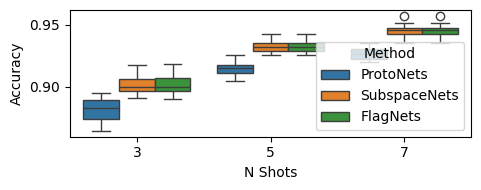

In [7]:
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt

res = pd.read_csv('../results/flowers_probing_rebuttal1.csv')

plt.figure(figsize = (5,2))
sns.boxplot(res, x = 'N Shots', y = 'Accuracy', hue = 'Method')
plt.tight_layout()
plt.savefig('../results/flowers_probing_rebuttal1.pdf', bbox_inches = "tight")